# Line Tracing #

## Idea ##

Function: Main
1) Load 1 pixel Image
2) Give every pixel a id
3) Select a Starting Point
Function: Trace Line
1) Check all Pixels surrounding the Starting Point

In [1]:
import utils
import classes
import matplotlib.pyplot as plt
import networkx as nx
import igraph as g
import json

In [2]:
imageArray = utils.load1BitBWImage("./../src/testImages/","0.png")
colorImage = utils.loadRGBImage("./../src/testImages/","newThin.png")

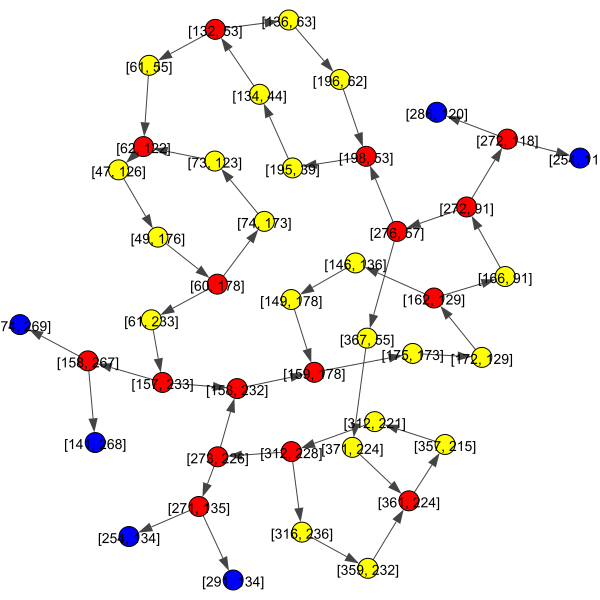

In [3]:
imageArray = utils.load1BitBWImage("./../src/testImages/","newThin.png")

class NodeType():
    pass
class EndNode(NodeType):
    pass
class IntersectionNode(NodeType):
    pass 
class CornerNode(NodeType):
    pass

class Gradient():
    def __init__(self,startCoord) -> None:
        self.dirList = []
        self.currentDir = 0
        self.lastDir = 0
        self.lastCoord = startCoord
        self.igNext = False
    def addDir(self,dir):
        self.dirList.append(dir)
        if (sum(self.dirList[-4:-1]))/3 < 0.5:
            self.currentDir = 0
        else:
            self.currentDir = 1
    def checkDirChange(self):
        if not self.lastDir == self.currentDir:
            self.lastDir = self.currentDir
            if self.igNext:
                self.igNext = False
                return False
            return True
        self.lastDir = self.currentDir
        return False
        
    def addCoord(self,coord):
        if(abs(coord[0] - self.lastCoord[0]) < abs(coord[1] - self.lastCoord[1])):
            self.addDir(1)
        else:
            self.addDir(0)
        self.lastCoord = coord
    def ignoreNext(self):
        self.igNext = True
        

def getAdjacentPixel(image,currentPixel,blackList):
    #AdjacentPixel Array       
    adjacentPixels = [[-1,-1],[0,-1],[1,-1], \
                        [-1,0],        [1,0], \
                        [-1,1], [0,1], [1,1]]
    validPixels = []
    for adj in adjacentPixels:
        adjacentPixel = [currentPixel[0]+adj[0],currentPixel[1]+adj[1]]
        if image[adjacentPixel[1]][adjacentPixel[0]] == 1:
            if not adjacentPixel in blackList:
                validPixels.append(adjacentPixel)
    return validPixels

# gets first black pixel in image
def findStaringPoint(image):
    for y in range(0,len(image)):
        for x in range(0,len(image)):
            if image[y][x] == 1:
                return [x,y]

## Runs along line until it finds the first Intersection or the first Endpoint
def findValidPoint(image,startPoint):
    def recursiveFindValidPoint(currentPixel,lastPixel):
        adjacentPixels = getAdjacentPixel(image,currentPixel,[])
        if len(adjacentPixels) > 2:
            return currentPixel
        if len(adjacentPixels) == 1:
            return currentPixel
        adjacentPixels = getAdjacentPixel(image,currentPixel,[lastPixel]) 
        return recursiveFindValidPoint(adjacentPixels[0],currentPixel)
    return recursiveFindValidPoint(startPoint,None)



def generateGraph(image,startPoint):
    visitedPixels = []
    graph = g.Graph(directed=True)
    graph.add_vertex(str(startPoint), label=str(startPoint) ,color="red")
    
    def recursiveGenerateGraph(currentPixel,lastPixel,lastGraphNode,dirGradientOld):
        dirGradient = list(dirGradientOld)

        #get Direction
        if(abs(currentPixel[0] - lastPixel[0]) < abs(currentPixel[1] - lastPixel[1])):
            dirGradient.append(1)
        else:
            dirGradient.append(0)

        #End Recursion if loop ends
        if currentPixel in visitedPixels:
            if len(graph.vs.select(name=str(currentPixel))):
                graph.add_edge(str(lastGraphNode),str(currentPixel))
            return

        visitedPixels.append(currentPixel)
        adjacentPixels = getAdjacentPixel(image,currentPixel,[lastPixel])
        if len(adjacentPixels) == 0:
            #ENDPOINT
            if(str(currentPixel) != lastGraphNode):
                graph.add_vertex(str(currentPixel),label=str(currentPixel),color="blue", nodeType=EndNode())
                graph.add_edge(str(lastGraphNode),str(currentPixel))
        elif len(adjacentPixels) == 1:
            #LINE
            if len(dirGradient) > 6:
                currDire = sum(dirGradient[-4:])/4 < 0.5
                lastDire = sum(dirGradient[-5:-1])/4 < 0.5
                if not  currDire == lastDire:
                    graph.add_vertex(str(currentPixel),label=str(currentPixel),color="yellow")
                    graph.add_edge(str(lastGraphNode),str(currentPixel))
                    colorImage[currentPixel[1],currentPixel[0]] = (0,255,255,255)
                    recursiveGenerateGraph(adjacentPixels[0],currentPixel,str(currentPixel),dirGradient)
                else:
                    recursiveGenerateGraph(adjacentPixels[0],currentPixel,lastGraphNode,dirGradient)
            else:
                recursiveGenerateGraph(adjacentPixels[0],currentPixel,lastGraphNode,dirGradient)
        else:
            #INTERSECTION
            if(str(currentPixel) != lastGraphNode):
                graph.add_vertex(str(currentPixel),label=str(currentPixel),color="red",nodeType=IntersectionNode())
                graph.add_edge(str(lastGraphNode),str(currentPixel))
            for adjacentPixel in adjacentPixels:
                recursiveGenerateGraph(adjacentPixel,currentPixel,str(currentPixel),[])

    recursiveGenerateGraph(startPoint,[0,0],str(startPoint),[])
    return graph,visitedPixels

graphCollection = []
while True:
    startingPoint = findStaringPoint(imageArray)
    startingPoint = findValidPoint(imageArray,startingPoint)
    G,visitedPixels = generateGraph(imageArray,startingPoint)
    graphCollection.append(G)
    #Remove all visited Pixels
    for visitedPixel in visitedPixels:
        imageArray[visitedPixel[1]][visitedPixel[0]] = 0
    
    #Check if image is only white
    summe = 0
    def addSum(pixel):global summe; summe += pixel
    utils.foreachPixel(imageArray,addSum)
    if summe < 10:
        break

union = g.union(graphCollection)

layout = union.layout("large_graph")
g.plot(union, layout=layout)


#### Pattern detection

In [45]:
def getColorList(graph):
    colorList = []
    for vert in graph.vs:
        if vert["color"] == "red":
            colorList.append(0)
        elif vert["color"] == "blue":
            colorList.append(1)
        elif vert["color"] == "yellow":
            colorList.append(2)
        elif vert["color"] == "white":
            colorList.append(3)
    return colorList

def getPatternMatches(graph,pattern):
    mapings = graph.get_subisomorphisms_vf2(pattern,color1=getColorList(graph),color2=getColorList(pattern))
    result = []
    for i in range(0,len(mapings),1):
        result.append(sorted(list( map(lambda node:json.loads(union.vs.find(node)["label"]) ,mapings[i]) )))

    #remove duplicated
    final = []
    for i in result:
        if i not in final:
            final.append(i)
    return final

def connectCapsTougehter(graph):
    ground = g.Graph(directed=True)
    ground.add_vertex(0,color="blue")
    ground.add_vertex(1,color="red")
    ground.add_vertex(2,color="blue")
    ground.add_edge(1,0)
    ground.add_edge(1,2)

    capMatches = getPatternMatches(graph,ground)
    for cap1Match in capMatches:
        cap1Coord = cap1Match[1]
        for cap2Match in capMatches:
            cap2Coord = cap2Match[1]
            if not cap2Coord == cap1Coord:
                if abs(cap2Coord[0] - cap1Coord[0]) < 5:
                    graph.vs.select(name=str(cap1Coord))['color'] = "white"
                    graph.vs.select(name=str(cap1Coord))['color'] = "white"
                    graph.add_edge(str(cap1Coord),str(cap2Coord))
                elif abs(cap2Coord[1] - cap1Coord[1]) < 5:
                    graph.vs.select(name=str(cap1Coord))['color'] = "white"
                    graph.vs.select(name=str(cap1Coord))['color'] = "white"
                    graph.add_edge(str(cap1Coord),str(cap2Coord))
    return graph

def groundPattern():
    ground = g.Graph(directed=True)
    ground.add_vertex(0,color="blue")
    ground.add_vertex(1,color="red")
    ground.add_vertex(2,color="blue")
    ground.add_edge(1,0)
    ground.add_edge(1,2)
    return ground

def capPattern():
    cap = g.Graph(directed=True)
    cap.add_vertex(0,color="blue")
    cap.add_vertex(1,color="white")
    cap.add_vertex(2,color="blue")
    cap.add_edge(1,0)
    cap.add_edge(1,2)

    cap.add_vertex(3,color="blue")
    cap.add_vertex(4,color="white")
    cap.add_vertex(5,color="blue")
    cap.add_edge(4,3)
    cap.add_edge(4,5)

    cap.add_edge(4,1)
    cap.add_edge(1,4)
    return cap

def resistorPattern():
    res = g.Graph(directed=True)
    res.add_vertex(0,color="red")
    res.add_vertex(1,color="yellow")
    res.add_vertex(2,color="yellow")
    res.add_vertex(3,color="red")
    res.add_vertex(4,color="yellow")
    res.add_vertex(5,color="yellow")
    res.add_edge(0,1)
    res.add_edge(1,2)
    res.add_edge(2,3)
    res.add_edge(3,4)
    res.add_edge(4,5)
    res.add_edge(5,0)
    return res

def generateBoundingBox(listOfCoords,offset):
    xCoords = list(map(lambda x: x[0],listOfCoords))
    yCoords = list(map(lambda y: y[1],listOfCoords))

    #get smalles and biggest of each and create Box
    from_ = [min(xCoords)-offset,min(yCoords)-offset]
    to_ = [max(xCoords)+offset,max(yCoords)+offset]
    return [from_,to_]


In [35]:
union = connectCapsTougehter(union)

[[[249, 113], [296, 140]], [[127, 34], [203, 68]], [[42, 117], [79, 183]], [[141, 124], [180, 183]], [[307, 210], [366, 241]], [[136, 262], [179, 274]]]


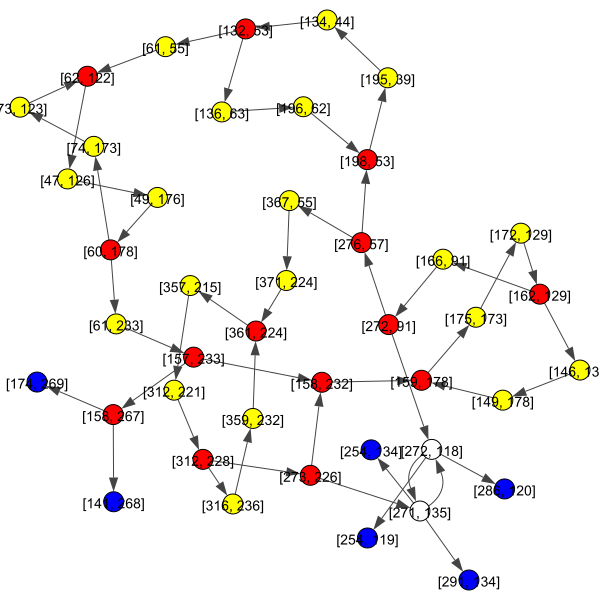

In [46]:
matches = getPatternMatches(union,capPattern()) + getPatternMatches(union,resistorPattern()) + getPatternMatches(union,groundPattern())
boundingBoxes = list(map(lambda x: generateBoundingBox(x,5),matches))
print(boundingBoxes)

layout = union.layout("large_graph")
g.plot(union, layout=layout)

[249, 113]
[127, 34]
[42, 117]
[141, 124]
[307, 210]
[136, 262]


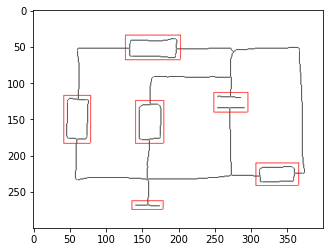

In [49]:
def drawRect(image,boundingBoxes,color):
    corner1 = boundingBoxes[0]
    corner2 = boundingBoxes[1]
    startX = corner1[0]
    startY = corner1[1]

    endX = corner2[0]
    endY = corner2[1]

    for x in range(startX,endX):
        image[startY][x] = color
        image[endY][x] = color

    for y in range(startY,endY):
        image[y][startX] = color
        image[y][endX] = color

    return image

for boundingBox in boundingBoxes:
    drawRect(colorImage,boundingBox,(255,0,0,255))
plt.imshow(colorImage,interpolation="bilinear")